In [1]:
#==================================================
# Imports
#==================================================
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray
import datetime
import calendar
import matplotlib
import os
#import h5py
import PseudoNetCDF as pnc
from scipy.ndimage import label
import scipy.interpolate as interp
import pickle
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Read in Learjet data (bulk microphysics, state variables, and FFSSP probe), all publicly availble on the CAMP2Ex data portal (https://www-air.larc.nasa.gov/cgi-bin/ArcView/camp2ex)

In [2]:
start_date = datetime.datetime(2019,9,25)
date_str = '20190925'
path = '/discover/nobackup/mwstanfo/camp2ex_data/learjet/'+date_str+'/'
file_fcdp = path+'CAMP2Ex-FCDP_Learjet_'+date_str+'_R1.ict'
file_2ds10 = path+'CAMP2Ex-2DS10_Learjet_'+date_str+'_R0.ict'
file_hawk2ds10 = path+'CAMP2Ex-Hawk2DS10_Learjet_'+date_str+'_R0.ict'
file_hawk2ds50 = path+'CAMP2Ex-Hawk2DS50_Learjet_'+date_str+'_R0.ict'
file_hawkfcdp = path+'CAMP2Ex-HawkFCDP_Learjet_'+date_str+'_R1.ict'
file_bulk_props = path+'CAMP2Ex-CloudBulkProps_Learjet_'+date_str+'_R0.ICT'
file_hvps = path+'CAMP2Ex-HVPS_Learjet_'+date_str+'_R0.ict'
file_ffssp = path+'CAMP2Ex-FFSSP_Learjet_'+date_str+'_R0.ict'
file_state = path+'CAMP2Ex-Page0_Learjet_'+date_str+'_R0.ict'

# Process State & Bulk Props File to get cloud pass times

In [3]:
def process_state_bulk(state_file_name,bulk_file_name,start_date):
    """
    Processes the Bulk and State files from the Learjet flight.
    """
    
    
    #===========================================
    # State file
    #===========================================

    infile = pnc.pncopen(state_file_name, format = 'ffi1001')
    var_list = infile.variables
    keys = list(var_list.keys())
    #print(keys)
    # Make Datetime arrays
    secs_from_00z = var_list['Time_Start'].data
    nt = len(secs_from_00z)
    time = np.array([start_date + datetime.timedelta(seconds=secs_from_00z[dd]) for dd in range(nt)])
    
    # Pull out state properties
    pres_alt = var_list['Palt'].data # Pressure altitude (ft)
    temp = var_list['Temp'].data # temperature (C)
    dew = var_list['Dew'].data # dewpoint temperature (C)
    NevLWC = var_list['NevLWC'].data # Nevzorov LWC (g/m3)
    FSSPWC = var_list['FSSPWC'].data # FFSSP water content (g/m3)
    FCDPHWC = var_list['FCDPHWC'].data # Hawkeye-FCDP water content (g/m3)
    FCDPWC = var_list['FCDPWC'].data # FCDP water content (g/m3)
    NevTWC = var_list['NevTWC'].data # Nevzorov total water content (g/m3)
    VaV = var_list['VaV'].data # Vertical wind (updraft) (m/s)
    FSSPconc = var_list['FSSPConc'].data # FFSSP concentration (#/cc)
    FCDPHconc = var_list['FCDPHConc'].data # Hawkeye-FCDP concentration (#/cc)
    FCDPconc = var_list['FCDPConc'].data # FCDP concentration (#/cc)
    x2DSHsn10 = var_list['2DSHsn10'].data # SPEC 2D-S SN10 Concentration, H-channel (#/L)
    x2DSVsn10 = var_list['2DSVsn10'].data # SPEC 2D-S SN10 Concentration, V-channel (#/L)
    x2DSHNcar = var_list['2DSHNcar'].data # NCAR 2D-S Concentration, H-channel (#/L)
    x2DSVNcar = var_list['2DSVNcar'].data # NCAR 2D-S Concentration, V-channel (#/L)
    x2DS10Hawk = var_list['2DS10Hawk'].data # Hawkeye-2DS 10um channel concentration (#/L)
    x2DS50Hawk = var_list['2DS50Hawk'].data # Hawkeye-2DS 50um channel concentration (#/L)
    HVPS = var_list['HVPS'].data # HVPS concentration (#/L)
    CPC = var_list['CPC'].data # CPC concentration (#/cc)
    PCASP = var_list['PCASP'].data # PCASP concentration (#/cc)
    lat = var_list['Lat'].data
    lon = var_list['Long'].data
    tas = var_list['TAS'].data

    #cloud_id = np.where(NevTWC >= 0.1)[0]
    #cloud_mask = np.zeros(np.shape(NevTWC))
    #cloud_mask[cloud_id] = 1
    #cloud_passes,num_cloud_passes = label(cloud_mask)
    
    state_dict = {'pres_alt':pres_alt,\
                'temp':temp,\
                'dew':dew,\
                'NevLWC':NevLWC,\
                'FSSPWC':FSSPWC,\
                'FCDPHWC':FCDPHWC,\
                'FCDPWC':FCDPWC,\
                'NevTWC':NevTWC,\
                'VaV':VaV,\
                'FSSPconc':FSSPconc,\
                'FCDPHconc':FCDPHconc,\
                'FCDPconc':FCDPconc,\
                '2DSHsn10':x2DSHsn10,\
                '2DSVsn10':x2DSVsn10,\
                '2DSHNcar':x2DSHNcar,\
                '2DSVNcar':x2DSVNcar,\
                '2DS10Hawk':x2DS10Hawk,\
                '2DS50Hawk':x2DS50Hawk,\
                'HVPS':HVPS,\
                'CPC':CPC,\
                'PCASP':PCASP,\
                #'cloud_mask':cloud_mask,\
                'time':time,\
                'lat':lat,\
                'lon':lon,\
                'tas':tas,\
               }
    
    
    #===========================================
    # Bulk Props File
    #===========================================    
    infile = pnc.pncopen(bulk_file_name, format = 'ffi1001')
    var_list = infile.variables
    keys = list(var_list.keys())

    # Make Datetime arrays
    secs_from_00z = var_list['Time_Start'].data
    nt = len(secs_from_00z)
    time = np.array([start_date + datetime.timedelta(seconds=secs_from_00z[dd]) for dd in range(nt)])

    cp_type = var_list['CP_Type'].data # (#), none, Cloud pass type, 1 = "Cloud" High Concentration of small particles (WC>0.1g/m3 for scatter probes in 1-50um range), 2 = "Precip" High Concentration of HVPS Particles (N>100/s), 3 = "Scud" Cloud Flag >0
    conc_L = var_list['Concentration_L'] #  (#/L), CldMicro_NumSizeDist_InSitu_Imaging_DroptoPrecip_AMB, Cloud-averaged composite total particle concentration from interpolated concentration PSD(1um-10mm)
    iwc = var_list['IWC_gm3'].data # (g/m3), CldMicro_TWC_InSitu_None_Bulk_AMB,  Cloud-averaged composite Ice water content (all particles treated as Ice) from interpolated concentration PSD (1um-10mm) using Brown and Francis 1995 method
    lwc = var_list['LWC_gm3'].data #  (g/m3), CldMicro_TWC_InSitu_None_Bulk_AMB, Cloud-averaged composite Liquid water content (all particles treated as liquid Rho = 1kg/L) from interpolated concentration PSD (1um-10mm) assuming all spherical particles
    reff = var_list['Reff_um'].data # (um),   CldMicro_MeanSize_InSitu_Imaging_DroptoPrecip_None, Cloud-averaged composite Effective Radius from interpolated concentration PSD (1um-10mm)
    ze = var_list['Z_dBz'].data # (dBz),  none, Cloud-averaged composite (Estimated) Radar Reflectivity from interpolated concentration PSD (1um-10mm)    
    ze = var_list['Z_dBz'].data # (dBz),  none, Cloud-averaged composite (Estimated) Radar Reflectivity from interpolated concentration PSD (1um-10mm)    
    
    
    bulk_dict = {'time':time,\
                 'lat':lat,\
                 'lon':lon,\
                 'cp_type':cp_type,\
                 'conc_L':conc_L,\
                 'iwc':iwc,\
                 'lwc':lwc,\
                 'reff':reff,\
                 'ze':ze}
        
    return state_dict,bulk_dict

# Create dictionaries holding bulk microphysical and state variable data from Learjet

In [4]:
state_dict,bulk_dict = process_state_bulk(file_state,file_bulk_props,start_date)

# Label Pre-defined "Cloud Passes", which are contiguous segments w/ LWC > 0.1 g/m3 as measured by the Nevzorov hotwire probe
## "Type 1" cloud passes are those defined w/ the LWC threshold, but are distinguished by "Type 2" by them being dominated by cloud droplets. Conversely, "Type 2" represent passes dominated by larger particles (i.e., low number concentrations)

In [5]:
nt = len(bulk_dict['time'])
cloud_mask_cp_type1 = np.zeros(nt)
cloud_mask_cp_type2 = np.zeros(nt)
cp_type = bulk_dict['cp_type']
cloud_id_type1 = np.where(cp_type == 1.)[0]

cloud_mask_cp_type1[cloud_id_type1] = 1
cp_type1,num_cp_type1 = label(cloud_mask_cp_type1)

cp_type1_time_dict = {}

#========================================
# Type 1 CP
#========================================
cp_id = 0
for ii in range(num_cp_type1):
    cloud_id = np.where(cp_type1 == ii+1)[0]
    
    start_id = cloud_id[0]
    end_id = cloud_id[-1]
    start_time = state_dict['time'][start_id]
    end_time = state_dict['time'][end_id]  
    
    cp_type1_time_dict[str(cp_id+1)] = {}
    cp_type1_time_dict[str(cp_id+1)]['start_time'] = start_time
    cp_type1_time_dict[str(cp_id+1)]['end_time'] = end_time
    cp_type1_time_dict[str(cp_id+1)]['start_id'] = start_id
    cp_type1_time_dict[str(cp_id+1)]['end_id'] = end_id
    
    cp_id+=1    

# Functions to process all instruments on the Learjet
## These include the FFSSP, FCDP, HawkFCDP, 2DS-10, Hawk2DS-10, Hawk2DS-50, and HVPS

In [6]:
def process_ffssp(file_name,cp_type1_time_dict,cloud_pass_id,min_thresh):
    """
    Processes FFSSP instrument
    """
    cloud_pass_id = str(cloud_pass_id)
    infile = pnc.pncopen(file_name, format = 'ffi1001')
    var_list = infile.variables
    keys = list(var_list.keys())
    
    # Make Datetime arrays
    secs_from_00z = var_list['Time_Start'].data
    nt = len(secs_from_00z)
    time = np.array([start_date + datetime.timedelta(seconds=secs_from_00z[dd]) for dd in range(nt)])
    
    # Pull out bulk properties
    twc = var_list['twc'].data
    conc = var_list['conc'].data
    ext = var_list['ext'].data
    cnt = var_list['CNT'].data
    sv = var_list['sv'].data
        
    # Make a dictionary that holds the concentrations for each bin
    cbin_dict = {}
    for key in keys:
        if 'cbin' in key:
            cbin_dict[key] = var_list[key].data
            
    # Make a dictionary that holds the concentrations for each bin
    nbin_dict = {}
    for key in keys:
        if 'nbin' in key:
            nbin_dict[key] = var_list[key].data
            
    # Create dictionary of #/L
    nbin_L_dict = {}
    for key,val in nbin_dict.items():
        dumid = np.where(val > 0)
        tmp_val = val.copy()
        tmp_val[dumid] = val[dumid]/sv[dumid]
        nbin_L_dict[key] = tmp_val
            
    sizes = [0,1.5,3,4.5,6,8,10,12,14,16,18,21,24,27,30,33,36,39,42,46,50]
    mid_sizes = np.array([0.5*(sizes[dd] + sizes[dd+1]) for dd in range(len(sizes)-1)])
          
    start_time = cp_type1_time_dict[cloud_pass_id]['start_time']
    end_time = cp_type1_time_dict[cloud_pass_id]['end_time']
        
    time_ids = np.where( (time >= start_time) & (time <= end_time) )

    #================================
    # Composite dN
    #================================    
    comp_dN = np.zeros(len(sizes)-1)
    nbin_keys = list(nbin_L_dict.keys())
    last_nbin_key = nbin_keys[-1]
    
    ii=0
    for key,val in nbin_L_dict.items():

        if key == last_nbin_key:
            continue
        tmp_vals = val[time_ids]
        tmp_vals[tmp_vals < 0.] = np.nan

        tmp_cnts = nbin_dict[key][time_ids]
        tmp_cnts[tmp_cnts < 0.] = np.nan
        tot_cnt = np.nansum(tmp_cnts)

        if tot_cnt > min_thresh:
            comp_dN[ii] = np.nanmean(tmp_vals)
        else:
            comp_dN[ii] = np.nan
        ii+=1
    comp_dN[comp_dN == 0.] = np.nan
  
    return comp_dN,mid_sizes,sizes

In [7]:
def process_hawkeye_2ds50(file_name,cp_type1_time_dict,cloud_pass_id,min_thresh):
    """
    Processes Hawkeye 2DS50 instrument
    """
    cloud_pass_id = str(cloud_pass_id)
    infile = pnc.pncopen(file_name, format = 'ffi1001')
    var_list = infile.variables
    keys = list(var_list.keys())
    
    # Make Datetime arrays
    secs_from_00z = var_list['Time_Start'].data
    nt = len(secs_from_00z)
    time = np.array([start_date + datetime.timedelta(seconds=secs_from_00z[dd]) for dd in range(nt)])
    
    # Pull out bulk properties
    twc = var_list['twc'].data
    conc = var_list['conc'].data
    ext = var_list['ext'].data
    sv = var_list['sv'].data
        
    # Make a dictionary that holds the concentrations for each bin
    cbin_dict = {}
    for key in keys:
        if 'cbin' in key:
            cbin_dict[key] = var_list[key].data
            
    # Make a dictionary that holds the concentrations for each bin
    nbin_dict = {}
    for key in keys:
        if 'nbin' in key:
            nbin_dict[key] = var_list[key].data                
            
    # Create dictionary of #/L
    nbin_L_dict = {}
    for key,val in nbin_dict.items():
        dumid = np.where(val > 0)
        tmp_val = val.copy()
        tmp_val[dumid] = val[dumid]/sv[dumid]
        nbin_L_dict[key] = tmp_val
            
    sizes_1 = np.arange(25,1075,50)
    sizes_2 = np.arange(1125,2625,100)
    sizes_3 = np.array([2775,3025,3225,3525,3775,4025,4275,4525,4775,5025,5525,6025,6525,7025,7525,8025,8525,9025,9525,10025,11025,12025,13025,14025,15025])
    sizes = np.concatenate((sizes_1,sizes_2,sizes_3))
        
    mid_sizes = np.array([0.5*(sizes[dd] + sizes[dd+1]) for dd in range(len(sizes)-1)])           
          
    start_time = cp_type1_time_dict[cloud_pass_id]['start_time']
    end_time = cp_type1_time_dict[cloud_pass_id]['end_time']
        
    time_ids = np.where( (time >= start_time) & (time <= end_time) )
        
    #================================
    # Composite dN
    #================================    
    comp_dN = np.zeros(len(sizes)-1)
    nbin_keys = list(nbin_L_dict.keys())
    last_nbin_key = nbin_keys[-1]
    
    ii=0
    for key,val in nbin_L_dict.items():

        if key == last_nbin_key:
            continue
        tmp_vals = val[time_ids]
        tmp_vals[tmp_vals < 0.] = np.nan

        tmp_cnts = nbin_dict[key][time_ids]
        tmp_cnts[tmp_cnts < 0.] = np.nan
        tot_cnt = np.nansum(tmp_cnts)

        if tot_cnt > min_thresh:
            comp_dN[ii] = np.nanmean(tmp_vals)
        else:
            comp_dN[ii] = np.nan
        ii+=1
    comp_dN[comp_dN == 0.] = np.nan
  
    return comp_dN,mid_sizes,sizes

In [8]:
def process_fcdp(file_name,cp_type1_time_dict,cloud_pass_id,min_thresh):
    """
    Processes FCDP instrument
    """
    cloud_pass_id = str(cloud_pass_id)
    infile = pnc.pncopen(file_name, format = 'ffi1001')
    var_list = infile.variables
    keys = list(var_list.keys())
    
    # Make Datetime arrays
    secs_from_00z = var_list['Time_Start'].data
    nt = len(secs_from_00z)
    time = np.array([start_date + datetime.timedelta(seconds=secs_from_00z[dd]) for dd in range(nt)])
    
    # Pull out bulk properties
    twc = var_list['twc'].data
    conc = var_list['conc'].data
    ext = var_list['ext'].data
    sv = var_list['sv'].data
        
    # Make a dictionary that holds the concentrations for each bin
    cbin_dict = {}
    for key in keys:
        if 'cbin' in key:
            cbin_dict[key] = var_list[key].data
            
    # Make a dictionary that holds the concentrations for each bin
    nbin_dict = {}
    for key in keys:
        if 'nbin' in key:
            nbin_dict[key] = var_list[key].data                

    # Create dictionary of #/L
    nbin_L_dict = {}
    for key,val in nbin_dict.items():
        dumid = np.where(val > 0)
        tmp_val = val.copy()
        tmp_val[dumid] = val[dumid]/sv[dumid]
        nbin_L_dict[key] = tmp_val
            
    sizes = np.array([0,1.5,3,4.5,6,8,10,12,14,16,18,21,24,27,30,33,36,39,42,46,50])
        
    mid_sizes = np.array([0.5*(sizes[dd] + sizes[dd+1]) for dd in range(len(sizes)-1)])           
          
    start_time = cp_type1_time_dict[cloud_pass_id]['start_time']
    end_time = cp_type1_time_dict[cloud_pass_id]['end_time']
        
    time_ids = np.where( (time >= start_time) & (time <= end_time) )
        
    #================================
    # Composite dN
    #================================    
    comp_dN = np.zeros(len(sizes)-1)
    nbin_keys = list(nbin_L_dict.keys())
    last_nbin_key = nbin_keys[-1]
    
    ii=0
    for key,val in nbin_L_dict.items():

        if key == last_nbin_key:
            continue
        tmp_vals = val[time_ids]
        tmp_vals[tmp_vals < 0.] = np.nan

        tmp_cnts = nbin_dict[key][time_ids]
        tmp_cnts[tmp_cnts < 0.] = np.nan
        tot_cnt = np.nansum(tmp_cnts)

        if tot_cnt > min_thresh:
            comp_dN[ii] = np.nanmean(tmp_vals)
        else:
            comp_dN[ii] = np.nan
        ii+=1
    comp_dN[comp_dN == 0.] = np.nan
  
    return comp_dN,mid_sizes,sizes    

In [9]:
def process_hvps(file_name,cp_type1_time_dict,cloud_pass_id,min_thresh):
    """
    Processes HVPS instrument
    """
    cloud_pass_id = str(cloud_pass_id)
    infile = pnc.pncopen(file_name, format = 'ffi1001')
    var_list = infile.variables
    keys = list(var_list.keys())
    
    # Make Datetime arrays
    secs_from_00z = var_list['Time_Start'].data
    nt = len(secs_from_00z)
    time = np.array([start_date + datetime.timedelta(seconds=secs_from_00z[dd]) for dd in range(nt)])
    
    # Pull out bulk properties
    twc = var_list['twc'].data
    conc = var_list['conc'].data
    ext = var_list['ext'].data
    #cnt = var_list['CNT'].data
    sv = var_list['sv'].data
        
    # Make a dictionary that holds the concentrations for each bin
    cbin_dict = {}
    for key in keys:
        if 'cbin' in key:
            cbin_dict[key] = var_list[key].data
            
    # Make a dictionary that holds the concentrations for each bin
    nbin_dict = {}
    for key in keys:
        if 'nbin' in key:
            nbin_dict[key] = var_list[key].data                

    # Create dictionary of #/L
    nbin_L_dict = {}
    for key,val in nbin_dict.items():
        dumid = np.where(val > 0)
        tmp_val = val.copy()
        tmp_val[dumid] = val[dumid]/sv[dumid]
        nbin_L_dict[key] = tmp_val
            
    sizes = np.array([75,225,375,525,675,825,975,1125,1275,1425,1575,1725,1875,2025,2175,2325,2475,2625,2775,2925,3075,3375,3675,3975,4275,4575,4875,5175,5475,5775,6075,6375,6675,6975,7275,7575,8325,9075,9825,10575,11325,12074,12824,13574,\
                     14325,15075,16575,18074,19574,21075,22574,24074,25574,27074,28574,30075,33075,36075,39075,42075,45075])

    mid_sizes = np.array([0.5*(sizes[dd] + sizes[dd+1]) for dd in range(len(sizes)-1)])           
          
    start_time = cp_type1_time_dict[cloud_pass_id]['start_time']
    end_time = cp_type1_time_dict[cloud_pass_id]['end_time']
        
    time_ids = np.where( (time >= start_time) & (time <= end_time) )
        

    #================================
    # Composite dN
    #================================    
    comp_dN = np.zeros(len(sizes)-1)
    nbin_keys = list(nbin_L_dict.keys())
    last_nbin_key = nbin_keys[-1]
    
    ii=0
    for key,val in nbin_L_dict.items():

        if key == last_nbin_key:
            continue
        tmp_vals = val[time_ids]
        tmp_vals[tmp_vals < 0.] = np.nan

        tmp_cnts = nbin_dict[key][time_ids]
        tmp_cnts[tmp_cnts < 0.] = np.nan
        tot_cnt = np.nansum(tmp_cnts)

        if tot_cnt > min_thresh:
            comp_dN[ii] = np.nanmean(tmp_vals)
        else:
            comp_dN[ii] = np.nan
        ii+=1
    comp_dN[comp_dN == 0.] = np.nan
  
    return comp_dN,mid_sizes,sizes      

In [10]:
def process_2ds10(file_name,cp_type1_time_dict,cloud_pass_id,min_thresh):
    """
    Processes 2DS10 instrument
    """
    cloud_pass_id = str(cloud_pass_id)
    infile = pnc.pncopen(file_name, format = 'ffi1001')
    var_list = infile.variables
    keys = list(var_list.keys())
    
    # Make Datetime arrays
    secs_from_00z = var_list['Time_Start'].data
    nt = len(secs_from_00z)
    time = np.array([start_date + datetime.timedelta(seconds=secs_from_00z[dd]) for dd in range(nt)])
    
    # Pull out bulk properties
    twc = var_list['twc'].data
    conc = var_list['conc'].data
    ext = var_list['ext'].data
    #cnt = var_list['CNT'].data
    sv = var_list['sv'].data
        
    # Make a dictionary that holds the concentrations for each bin
    # Number/L/um
    cbin_dict = {}
    for key in keys:
        if 'cbin' in key:
            cbin_dict[key] = var_list[key].data
            
    # Make a dictionary that holds the counts for each bin
    # Number only
    nbin_dict = {}
    for key in keys:
        if 'nbin' in key:
            nbin_dict[key] = var_list[key].data                

            
    # Create dictionary of #/L
    # Number/liter
    nbin_L_dict = {}
    for key,val in nbin_dict.items():
        dumid = np.where(val > 0)
        tmp_val = val.copy()
        tmp_val[dumid] = val[dumid]/sv[dumid]
        nbin_L_dict[key] = tmp_val

    sizes_1 = np.arange(5,215,10)
    sizes_2 = np.arange(225,525,20)
    sizes_3 = np.arange(555,1055,50)
    sizes_4 = np.arange(1105,2105,100)
    sizes_5 = np.arange(2205,3205,200)
    sizes = np.concatenate((sizes_1,sizes_2,sizes_3,sizes_4,sizes_5))
    
    mid_sizes = np.array([0.5*(sizes[dd] + sizes[dd+1]) for dd in range(len(sizes)-1)])           
          
    start_time = cp_type1_time_dict[cloud_pass_id]['start_time']
    end_time = cp_type1_time_dict[cloud_pass_id]['end_time']
        
    time_ids = np.where( (time >= start_time) & (time <= end_time) )
    
    #================================
    # Composite dN
    #================================    
    comp_dN = np.zeros(len(sizes)-1)
    nbin_keys = list(nbin_L_dict.keys())
    last_nbin_key = nbin_keys[-1]
    
    ii=0
    for key,val in nbin_L_dict.items():

        if key == last_nbin_key:
            continue
        tmp_vals = val[time_ids]
        tmp_vals[tmp_vals < 0.] = np.nan

        tmp_cnts = nbin_dict[key][time_ids]
        tmp_cnts[tmp_cnts < 0.] = np.nan
        tot_cnt = np.nansum(tmp_cnts)

        if tot_cnt > min_thresh:
            comp_dN[ii] = np.nanmean(tmp_vals)
        else:
            comp_dN[ii] = np.nan
        ii+=1
    comp_dN[comp_dN == 0.] = np.nan
  
    return comp_dN,mid_sizes,sizes    

# Analysis of cloud passes led to subjective choosing of 4 cloud passes to use in this study, representative of various thermodynamic and kinematic conditions with robust sample sizes
## Summaries of all cloud passes are provided on the NASA CAMP2Ex data portal (https://www-air.larc.nasa.gov/cgi-bin/ArcView/camp2ex?LEARJET=1)
## Below, define IDs for these 4 selected cloud passes

In [26]:
target_1_id = '14' # 19.41 deg C updraft near cloud base
target_2_id = '16' # long (60-second) cloud pass between 15 and 19 deg C (mean 17.5 deg C); ascent through continuous updraft
target_3_id = '8' # 7.28 deg C downdraft near cloud top 
target_4_id = '19' # 1.04 deg C relatively strong updraft of a growing turret

target_id_dict = {'1':target_1_id,\
                  '2':target_2_id,\
                  '3':target_3_id,\
                  '4':target_4_id}

#target_id_dict = {}
#for key in cp_type1_time_dict.keys():
#    target_id_dict[key] = key

# Make a dictionary for each cloud pass
## Under each cloud pass key is the DSD (dN, in units of /L, so not normalized by bin width) for each instrument

In [28]:
top_dict = {}

for key,val in target_id_dict.items():
    print(key)
    
    min_thresh = 0
    cloud_pass_id = val
    
    top_dict[cloud_pass_id] = {}
    
    time = state_dict['time']
    start_time = cp_type1_time_dict[cloud_pass_id]['start_time']
    end_time = cp_type1_time_dict[cloud_pass_id]['end_time']
    start_id = cp_type1_time_dict[cloud_pass_id]['start_id']
    end_id = cp_type1_time_dict[cloud_pass_id]['end_id']+1    
    

    ffssp_comp_dN,ffssp_mid_sizes,ffssp_sizes = process_ffssp(file_ffssp,cp_type1_time_dict,cloud_pass_id,min_thresh)
    fcdp_comp_dN,fcdp_mid_sizes,fcdp_sizes = process_fcdp(file_fcdp,cp_type1_time_dict,cloud_pass_id,min_thresh)
    hawkeye_fcdp_comp_dN,fcdp_mid_sizes,fcdp_sizes = process_fcdp(file_hawkfcdp,cp_type1_time_dict,cloud_pass_id,min_thresh)
    x2ds10_comp_dN,x2ds10_mid_sizes,x2ds10_sizes = process_2ds10(file_2ds10,cp_type1_time_dict,cloud_pass_id,min_thresh)
    hawkeye_2ds10_comp_dN,x2ds10_mid_sizes,x2ds10_sizes = process_2ds10(file_hawk2ds10,cp_type1_time_dict,cloud_pass_id,min_thresh)
    hawkeye_2ds50_comp_dN,hawkeye_2ds50_mid_sizes,hawkeye_2ds50_sizes = process_hawkeye_2ds50(file_hawk2ds50,cp_type1_time_dict,cloud_pass_id,min_thresh)
    hvps_comp_dN,hvps_mid_sizes,hvps_sizes = process_hvps(file_hvps,cp_type1_time_dict,cloud_pass_id,min_thresh)

    
    # Put all DSDs into dictionary
    dsd_dict = {'ffssp':{},\
                'fcdp':{},\
                'hawkfcdp':{},\
                '2ds10':{},\
                'hawk2ds10':{},\
                'hawk2ds50':{},\
                'hvps':{},\
               }
    dsd_dict['ffssp']['dsd'] = ffssp_comp_dN
    dsd_dict['ffssp']['sizes'] = ffssp_sizes
    dsd_dict['ffssp']['mid_sizes'] = ffssp_mid_sizes
    dsd_dict['fcdp']['dsd'] = fcdp_comp_dN
    dsd_dict['fcdp']['sizes'] = fcdp_sizes  
    dsd_dict['fcdp']['mid_sizes'] = fcdp_mid_sizes  
    dsd_dict['hawkfcdp']['dsd'] = hawkeye_fcdp_comp_dN
    dsd_dict['hawkfcdp']['sizes'] = fcdp_sizes  
    dsd_dict['hawkfcdp']['mid_sizes'] = fcdp_mid_sizes  
    dsd_dict['2ds10']['dsd'] = x2ds10_comp_dN
    dsd_dict['2ds10']['sizes'] = x2ds10_sizes 
    dsd_dict['2ds10']['mid_sizes'] = x2ds10_mid_sizes 
    dsd_dict['hawk2ds10']['dsd'] = hawkeye_2ds10_comp_dN
    dsd_dict['hawk2ds10']['sizes'] = x2ds10_sizes  
    dsd_dict['hawk2ds10']['mid_sizes'] = x2ds10_mid_sizes  
    dsd_dict['hawk2ds50']['dsd'] = hawkeye_2ds50_comp_dN
    dsd_dict['hawk2ds50']['sizes'] = hawkeye_2ds50_sizes 
    dsd_dict['hawk2ds50']['mid_sizes'] = hawkeye_2ds50_mid_sizes 
    dsd_dict['hvps']['dsd'] = hvps_comp_dN
    dsd_dict['hvps']['sizes'] = hvps_sizes  
    dsd_dict['hvps']['mid_sizes'] = hvps_mid_sizes  
    
    #========================
    # Grab some bulk/state properties as well
    #========================
    
    mean_conc = np.mean(bulk_dict['conc_L'][start_id:end_id])*1.e-3
    mean_lwc = np.mean(bulk_dict['lwc'][start_id:end_id])  
    mean_iwc = np.mean(bulk_dict['iwc'][start_id:end_id])
    mean_dbz = np.mean(bulk_dict['ze'][start_id:end_id])
    mean_reff = np.mean(bulk_dict['reff'][start_id:end_id])
    
    w_out = state_dict['VaV'][start_id:end_id]
    nev_lwc_out = state_dict['NevLWC'][start_id:end_id]
    nev_twc_out = state_dict['NevTWC'][start_id:end_id]
    fcdp_wc_out = state_dict['FCDPWC'][start_id:end_id]
    fssp_wc_out = state_dict['FSSPWC'][start_id:end_id]
    fcdp_hawk_wc_out = state_dict['FCDPHWC'][start_id:end_id]
    
    fcdp_conc_out = state_dict['FCDPconc'][start_id:end_id]
    fssp_conc_out = state_dict['FSSPconc'][start_id:end_id]
    fcdp_hawk_conc_out = state_dict['FCDPHconc'][start_id:end_id]
    hvps_conc_out = state_dict['HVPS'][start_id:end_id]
    x2ds50_hawk_conc_out = state_dict['2DS50Hawk'][start_id:end_id]
    x2dshsn10_conc_out = state_dict['2DSHsn10'][start_id:end_id]
    x2dsvsn10_conc_out = state_dict['2DSVsn10'][start_id:end_id]
    x2ds10_hawk_conc_out = state_dict['2DS10Hawk'][start_id:end_id]
    temp_out = state_dict['temp'][start_id:end_id]
    dew_out = state_dict['dew'][start_id:end_id]  
    
    # Calculate RH
    beta = 17.625
    lamb = 243.04
    num = np.exp( (beta*state_dict['dew']) / (lamb + state_dict['dew']) )
    den = np.exp( (beta*state_dict['temp']) / (lamb + state_dict['temp']) )
    rh = 100. * (num/den)
    
    rh_out = rh[start_id:end_id]
    alt_out = state_dict['pres_alt'][start_id:end_id]*0.3048
    
    cp_dict = {'conc_cc':bulk_dict['conc_L'][start_id:end_id].data*1.e-3,\
           'lwc':bulk_dict['lwc'][start_id:end_id],\
           'NevLWC':state_dict['NevLWC'][start_id:end_id],\
           'NevTWC':state_dict['NevTWC'][start_id:end_id],\
           'FFSSP_conc':fssp_conc_out,\
           'FCDP_conc':fcdp_conc_out,\
           'FCDP_hawk_conc':fcdp_hawk_conc_out,\
           'HVPS_conc':hvps_conc_out,\
           '2DS50_hawk_conc':x2ds50_hawk_conc_out,\
           '2DS10_hawk_conc':x2ds10_hawk_conc_out,\
           '2DSH10_conc':x2dshsn10_conc_out,\
           '2DSV10_conc':x2dsvsn10_conc_out,\
           'iwc':bulk_dict['iwc'][start_id:end_id],\
           'dbz':bulk_dict['ze'][start_id:end_id],\
           'reff':bulk_dict['reff'][start_id:end_id],\
           'lat':bulk_dict['lat'][start_id:end_id],\
           'lon':bulk_dict['lon'][start_id:end_id],\
           'temp':temp_out,\
           'mean_temp':np.mean(temp_out),\
           'max_temp':np.max(temp_out),\
           'min_temp':np.min(temp_out),\
           'dew':dew_out,\
           'rh':rh_out,\
           'alt':alt_out,\
           'w':w_out,\
           'mean_w':np.mean(w_out),\
           'max_w':np.max(w_out),\
           'min_w':np.min(w_out),\
           'mean_NevLWC':np.mean(state_dict['NevLWC'][start_id:end_id]),\
           'max_NevLWC':np.max(state_dict['NevLWC'][start_id:end_id]),\
           'min_NevLWC':np.min(state_dict['NevLWC'][start_id:end_id]),\
           'time':time[start_id:end_id],\
           'tas':state_dict['tas'][start_id:end_id]
          }
    
    top_dict[cloud_pass_id]['bulk_dict'] = cp_dict
    top_dict[cloud_pass_id]['dsd_dict'] = dsd_dict

1
2
3
4


# Based on continuity of DSDs between instruments, need to manually choose a size threshold to stitch instruments for each cloud pass
## This was done by analyzing the DSDs from the individual instruments in dN/dlogD units (third plot below, and the one that is included in the manuscript)

In [29]:
use_2ds50 = False

split_dict = {}
dumi = 0
for key in top_dict.keys():
    split_dict[key] = {}
    
    if dumi == 0.:
        split_ffssp_2ds10 = 45
        if use_2ds50:
            split_2ds10_2ds50 = 100
            split_2ds50_hvps = 250
        else:
            split_2ds10_hvps = 250
        
    if dumi == 1.:
        split_ffssp_2ds10 = 40
        if use_2ds50:
            split_2ds10_2ds50 = 80
            split_2ds50_hvps = 400
        else:
            split_2ds10_hvps = 400
        
    if dumi == 2.:
        split_ffssp_2ds10 = 45
        if use_2ds50:
            split_2ds10_2ds50 = 100
            split_2ds50_hvps = 500
        else:
            split_2ds10_hvps = 300
        
    if dumi == 3.:
        split_ffssp_2ds10 = 48
        if use_2ds50:
            split_2ds10_2ds50 = 300
            split_2ds50_hvps = 500
        else:
            split_2ds10_hvps = 550
        
    split_dict[key]['split_ffssp_2ds10'] = split_ffssp_2ds10
    if use_2ds50:
        split_dict[key]['split_2ds10_2ds50'] = split_2ds10_2ds50
        split_dict[key]['split_2ds50_hvps'] = split_2ds50_hvps
    else:
        split_dict[key]['split_2ds10_hvps'] = split_2ds10_hvps
    
    dumi+=1

# Make composite distributions
## The resulting dictionary will hold dN, dNdD (dN divided by the bin width), and dNdlogD (dN divided by log_10(i+1) - log_10(i), where i is a given bin edge)

In [30]:
comp_dict = {}


for key in top_dict.keys():
    
    comp_dict[key] = {}
    
    tmp_ffssp_dN = top_dict[key]['dsd_dict']['ffssp']['dsd'] # dN in units of #/L
    ffssp_sizes = top_dict[key]['dsd_dict']['ffssp']['sizes']
    ffssp_mid_sizes = top_dict[key]['dsd_dict']['ffssp']['mid_sizes']
    ffssp_dlogD = np.diff(np.log10(ffssp_sizes))
    ffssp_dD = np.diff(ffssp_sizes)

    tmp_2ds10_dN = top_dict[key]['dsd_dict']['2ds10']['dsd'] # dN in units of #/L
    x2ds10_sizes = top_dict[key]['dsd_dict']['2ds10']['sizes']
    x2ds10_mid_sizes = top_dict[key]['dsd_dict']['2ds10']['mid_sizes']
    x2ds10_dlogD = np.diff(np.log10(x2ds10_sizes))
    x2ds10_dD = np.diff(x2ds10_sizes)
    
    tmp_hawk2ds50_dN = top_dict[key]['dsd_dict']['hawk2ds50']['dsd'] # dN in units of #/L
    hawk2ds50_sizes = top_dict[key]['dsd_dict']['hawk2ds50']['sizes']
    hawk2ds50_mid_sizes = top_dict[key]['dsd_dict']['hawk2ds50']['mid_sizes']
    hawk2ds50_dlogD = np.diff(np.log10(hawk2ds50_sizes))
    hawk2ds50_dD = np.diff(hawk2ds50_sizes)
    
    tmp_hvps_dN = top_dict[key]['dsd_dict']['hvps']['dsd'] # dN in units of #/L
    hvps_sizes = top_dict[key]['dsd_dict']['hvps']['sizes']
    hvps_mid_sizes = top_dict[key]['dsd_dict']['hvps']['mid_sizes']
    hvps_dlogD = np.diff(np.log10(hvps_sizes))
    hvps_dD = np.diff(hvps_sizes)
    


    
    if use_2ds50:
        split_ffssp_2ds10_size = split_dict[key]['split_ffssp_2ds10']
        split_2ds10_2ds50_size = split_dict[key]['split_2ds10_2ds50']
        split_2ds50_hvps_size = split_dict[key]['split_2ds50_hvps']


        split1_id = np.where(ffssp_mid_sizes <= split_ffssp_2ds10_size)[0][:-1]
        split2_id = np.where((x2ds10_mid_sizes > split_ffssp_2ds10_size) & (x2ds10_mid_sizes <= split_2ds10_2ds50_size) )[0][:-1]
        split3_id = np.where((hawkeye_2ds50_mid_sizes > split_2ds10_2ds50_size) & (hawkeye_2ds50_mid_sizes <= split_2ds50_hvps_size) )[0][:-1]
        split4_id = np.where(hvps_mid_sizes > split_2ds50_hvps_size )[0][:-1]
    
    else:
        split_ffssp_2ds10_size = split_dict[key]['split_ffssp_2ds10']
        split_2ds10_hvps_size = split_dict[key]['split_2ds10_hvps']    

        split1_id = np.where(ffssp_mid_sizes <= split_ffssp_2ds10_size)[0][:-1]
        split2_id = np.where((x2ds10_mid_sizes > split_ffssp_2ds10_size) & (x2ds10_mid_sizes <= split_2ds10_hvps_size) )[0][:-1]
        split3_id = np.where(hvps_mid_sizes > split_2ds10_hvps_size )[0][:-1]
    
    comp_dN = []
    comp_sizes = []
    comp_dlogD = []
    comp_dD = []
    
    comp_dN.append(tmp_ffssp_dN[split1_id])
    comp_sizes.append(ffssp_mid_sizes[split1_id])
    comp_dlogD.append(ffssp_dlogD[split1_id])
    comp_dD.append(ffssp_dD[split1_id])
    
    comp_dN.append(tmp_2ds10_dN[split2_id])
    comp_sizes.append(x2ds10_mid_sizes[split2_id])
    comp_dlogD.append(x2ds10_dlogD[split2_id])
    comp_dD.append(x2ds10_dD[split2_id])
    
    if use_2ds50:
        comp_dN.append(tmp_hawk2ds50_dN[split3_id])
        comp_sizes.append(hawk2ds50_mid_sizes[split3_id])
        comp_dlogD.append(hawk2ds50_dlogD[split3_id])
        comp_dD.append(hawk2ds50_dD[split3_id])

        comp_dN.append(tmp_hvps_dN[split4_id])
        comp_sizes.append(hvps_mid_sizes[split4_id])
        comp_dlogD.append(hvps_dlogD[split4_id])
        comp_dD.append(hvps_dD[split4_id])
    
    else:
        comp_dN.append(tmp_hvps_dN[split3_id])
        comp_sizes.append(hvps_mid_sizes[split3_id])
        comp_dlogD.append(hvps_dlogD[split3_id])
        comp_dD.append(hvps_dD[split3_id])
    
    comp_dN = np.concatenate(comp_dN)
    comp_sizes = np.concatenate(comp_sizes) 
    comp_dlogD = np.concatenate(comp_dlogD)
    comp_dD = np.concatenate(comp_dD)
    
    
    if False:
        # Interpolate to grid with common spacing
        interp_sizes = np.arange(1,10001,1)
        f = interp.interp1d(comp_sizes,comp_dN,kind='nearest',fill_value=np.nan,bounds_error=False)     
        comp_dN_interp = f(interp_sizes)   

        mid_interp_sizes = np.array([0.5*(interp_sizes[dd] + interp_sizes[dd+1]) for dd in range(len(interp_sizes)-1)])
        mid_interp_sizes = np.concatenate([np.array([0.5]),mid_interp_sizes,np.array([10000.5])])

        comp_dict[key]['dsd_interp'] = comp_dN_interp
        comp_dict[key]['interp_sizes'] = interp_sizes
        comp_dict[key]['mid_interp_sizes'] = mid_interp_sizes 
    
    
    comp_dict[key]['dN'] = comp_dN
    comp_dict[key]['dNdD'] = comp_dN/comp_dD
    comp_dict[key]['dNdlogD'] = comp_dN/comp_dlogD
    comp_dict[key]['sizes'] = comp_sizes
    comp_dict[key]['dlogD'] = comp_dlogD
    comp_dict[key]['dD'] = comp_dD
    top_dict[key]['comp'] = comp_dict[key]
    
    
    #print(aaaaa)

/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_31174/206947441.py:11: RuntimeWarning: divide by zero encountered in log10
  ffssp_dlogD = np.diff(np.log10(ffssp_sizes))


# Plot dN/dlogD figure (Fig. D1 of the manuscript)

/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_31174/1369572772.py:62: RuntimeWarning: divide by zero encountered in log10
  dlogD = np.diff(np.log10(ffssp_sizes))


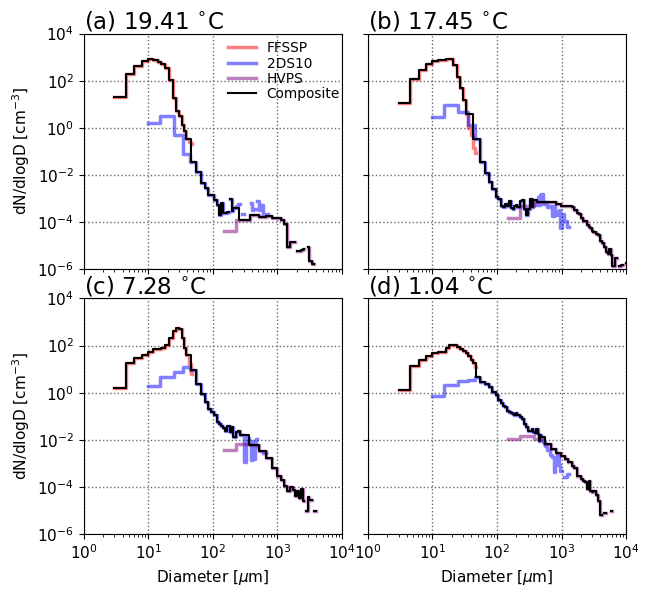

In [31]:
fig = plt.figure(figsize=(7,6.5))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

axlist = [ax1,ax2,ax3,ax4]
Fontsize=11
for ax in axlist:
    ax.tick_params(labelsize=Fontsize)
    ax.grid(which='major',lw=1,c='dimgrey',ls='dotted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1,1.e4)
    ax.set_ylim(1.e-6,1.e4)
    ax.set_yticks(10.**np.arange(-6,6,2))
    ax.set_xticks(10.**np.arange(0,5,1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    #ax.minorticks_on
    
ax3.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize)
ax4.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize)
ax1.set_ylabel('dN/dlogD [cm$^{-3}$]',fontsize=Fontsize)
ax3.set_ylabel('dN/dlogD [cm$^{-3}$]',fontsize=Fontsize)


dum_y_ticks = np.arange(-6,6,2)
new_y_ticks = []
for dum_y_tick in dum_y_ticks:
    new_y_ticks.append('10$^{'+str(int(dum_y_tick))+'}$')
ax1.set_yticklabels(new_y_ticks)
ax3.set_yticklabels(new_y_ticks)

dum_x_ticks = np.arange(0,5,1)
new_x_ticks = []
for dum_x_tick in dum_x_ticks:
    new_x_ticks.append('10$^{'+str(int(dum_x_tick))+'}$')
ax3.set_xticklabels(new_x_ticks)
ax4.set_xticklabels(new_x_ticks)

labs = ['(a)','(b)','(c)','(d)']
dumi=0
for key in top_dict.keys():
    tmp_mean_temp = np.around(top_dict[key]['bulk_dict']['mean_temp'],2)
    dum_str = labs[dumi]+' '+str(tmp_mean_temp)+' $^{\\circ}$C'
    axlist[dumi].text(0,1.1,dum_str,transform=axlist[dumi].transAxes,va='top',ha='left',fontsize=Fontsize*1.5)
    dumi+=1
    
    
dumi=0
for key in top_dict.keys():
    ax = axlist[dumi]
    alpha=0.5
    tmp_lw = 2.5
    #---------------------------------------
    # FFSSP
    #---------------------------------------
    tmp_ffssp_dN = top_dict[key]['dsd_dict']['ffssp']['dsd'] # dN in units of #/L
    ffssp_sizes = top_dict[key]['dsd_dict']['ffssp']['sizes']
    ffssp_mid_sizes = top_dict[key]['dsd_dict']['ffssp']['mid_sizes']
    dlogD = np.diff(np.log10(ffssp_sizes))
    tmp_ffssp_dsd = tmp_ffssp_dN*1.e-3/dlogD
    ax.step(ffssp_mid_sizes,tmp_ffssp_dsd,c='red',lw=tmp_lw,where='mid',alpha=alpha,label='FFSSP')

    #---------------------------------------
    # 2DS10
    #---------------------------------------
    tmp_2ds10_dN = top_dict[key]['dsd_dict']['2ds10']['dsd'] # dN in units of #/L
    x2ds10_sizes = top_dict[key]['dsd_dict']['2ds10']['sizes']
    x2ds10_mid_sizes = top_dict[key]['dsd_dict']['2ds10']['mid_sizes']
    dlogD = np.diff(np.log10(x2ds10_sizes))
    tmp_2ds10_dsd = tmp_2ds10_dN*1.e-3/dlogD
    ax.step(x2ds10_mid_sizes,tmp_2ds10_dsd,c='blue',lw=tmp_lw,where='mid',alpha=alpha,label='2DS10')    
    
    #---------------------------------------
    # Hawkeye 2DS50
    #---------------------------------------
    if use_2ds50:
        tmp_hawk2ds50_dN = top_dict[key]['dsd_dict']['hawk2ds50']['dsd'] # dN in units of #/L
        hawk2ds50_sizes = top_dict[key]['dsd_dict']['hawk2ds50']['sizes']
        hawk2ds50_mid_sizes = top_dict[key]['dsd_dict']['hawk2ds50']['mid_sizes']
        dumid = np.where(hawk2ds50_mid_sizes >= 300)[0]
        dlogD = np.diff(np.log10(hawk2ds50_sizes))
        tmp_hawk2ds50_dsd = tmp_hawk2ds50_dN*1.e-3/dlogD
        #ax.step(hawk2ds50_mid_sizes[dumid],tmp_hawk2ds50_dsd[dumid],c='green',lw=tmp_lw,where='mid',alpha=alpha,label='Hawk2DS50')        
        ax.step(hawk2ds50_mid_sizes,tmp_hawk2ds50_dsd,c='green',lw=tmp_lw,where='mid',alpha=alpha,label='Hawk2DS50')        
    
    #---------------------------------------
    # HVPS
    #---------------------------------------
    tmp_hvps_dN = top_dict[key]['dsd_dict']['hvps']['dsd'] # dN in units of #/L
    hvps_sizes = top_dict[key]['dsd_dict']['hvps']['sizes']
    hvps_mid_sizes = top_dict[key]['dsd_dict']['hvps']['mid_sizes']
    dlogD = np.diff(np.log10(hvps_sizes))
    tmp_hvps_dsd = tmp_hvps_dN*1.e-3/dlogD
    ax.step(hvps_mid_sizes,tmp_hvps_dsd,c='purple',lw=tmp_lw,where='mid',alpha=alpha,label='HVPS')   
    
    
    #---------------------------------------
    # Composite DSD
    #---------------------------------------
    #tmp_comp_dN = comp_dict[key]['dsd']
    tmp_comp_dNdlogD = comp_dict[key]['dNdlogD']*1.e-3
    tmp_comp_sizes = comp_dict[key]['sizes']
    #dlogD = comp_dict[key]['dlogD']
    #tmp_comp_dsd = tmp_comp_dN*1.e-3/dlogD
    #ax.step(tmp_comp_sizes,tmp_comp_dsd,c='k',lw=1.5,where='mid',alpha=1,label='Composite')
    ax.step(tmp_comp_sizes,tmp_comp_dNdlogD,c='k',lw=1.5,where='mid',alpha=1,label='Composite')
    
    dumi+=1

ax1.legend(loc='upper right',framealpha=False,fontsize=Fontsize*0.9,bbox_to_anchor=(1.04,1.02),labelspacing=0.1)

plt.subplots_adjust(wspace=0.1,hspace=0.125)

save_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
outfile = 'learjet_dsd_4_cloud_passes.png'
#plt.savefig(save_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()

# Plot dN figure (not included in manuscript, but included for context)

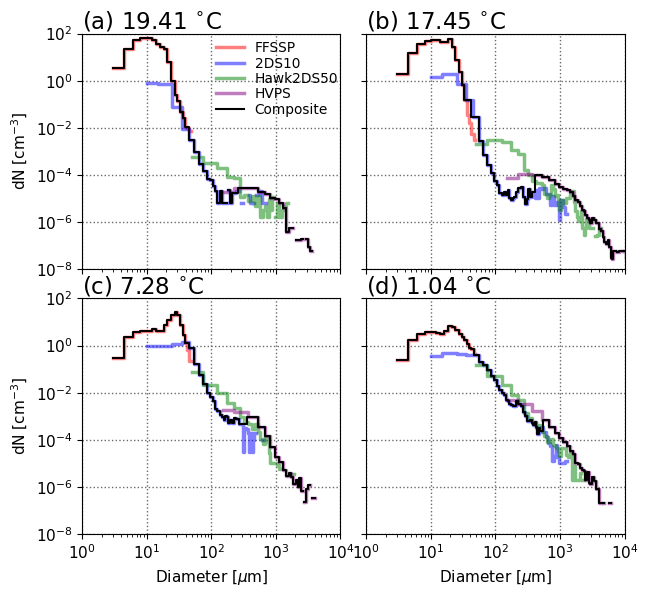

In [32]:
fig = plt.figure(figsize=(7,6.5))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

axlist = [ax1,ax2,ax3,ax4]
Fontsize=11
for ax in axlist:
    ax.tick_params(labelsize=Fontsize)
    ax.grid(which='major',lw=1,c='dimgrey',ls='dotted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1,1.e4)
    ax.set_ylim(1.e-8,1.e2)
    ax.set_yticks(10.**np.arange(-8,4,2))
    ax.set_xticks(10.**np.arange(0,5,1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    #ax.minorticks_on
    
ax3.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize)
ax4.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize)
ax1.set_ylabel('dN [cm$^{-3}$]',fontsize=Fontsize)
ax3.set_ylabel('dN [cm$^{-3}$]',fontsize=Fontsize)


dum_y_ticks = np.arange(-8,4,2)
new_y_ticks = []
for dum_y_tick in dum_y_ticks:
    new_y_ticks.append('10$^{'+str(int(dum_y_tick))+'}$')
ax1.set_yticklabels(new_y_ticks)
ax3.set_yticklabels(new_y_ticks)

dum_x_ticks = np.arange(0,5,1)
new_x_ticks = []
for dum_x_tick in dum_x_ticks:
    new_x_ticks.append('10$^{'+str(int(dum_x_tick))+'}$')
ax3.set_xticklabels(new_x_ticks)
ax4.set_xticklabels(new_x_ticks)

labs = ['(a)','(b)','(c)','(d)']
dumi=0
for key in top_dict.keys():
    tmp_mean_temp = np.around(top_dict[key]['bulk_dict']['mean_temp'],2)
    dum_str = labs[dumi]+' '+str(tmp_mean_temp)+' $^{\\circ}$C'
    axlist[dumi].text(0,1.1,dum_str,transform=axlist[dumi].transAxes,va='top',ha='left',fontsize=Fontsize*1.5)
    dumi+=1
    
    
dumi=0
for key in top_dict.keys():
    ax = axlist[dumi]
    alpha=0.5
    tmp_lw = 2.5
    #---------------------------------------
    # FFSSP
    #---------------------------------------
    tmp_ffssp_dN = top_dict[key]['dsd_dict']['ffssp']['dsd'] # dN in units of #/L
    ffssp_sizes = top_dict[key]['dsd_dict']['ffssp']['sizes']
    ffssp_mid_sizes = top_dict[key]['dsd_dict']['ffssp']['mid_sizes']
    tmp_ffssp_dsd = tmp_ffssp_dN*1.e-3
    ax.step(ffssp_mid_sizes,tmp_ffssp_dsd,c='red',lw=tmp_lw,where='mid',alpha=alpha,label='FFSSP')

    #---------------------------------------
    # 2DS10
    #---------------------------------------
    tmp_2ds10_dN = top_dict[key]['dsd_dict']['2ds10']['dsd'] # dN in units of #/L
    x2ds10_sizes = top_dict[key]['dsd_dict']['2ds10']['sizes']
    x2ds10_mid_sizes = top_dict[key]['dsd_dict']['2ds10']['mid_sizes']
    tmp_2ds10_dsd = tmp_2ds10_dN*1.e-3
    ax.step(x2ds10_mid_sizes,tmp_2ds10_dsd,c='blue',lw=tmp_lw,where='mid',alpha=alpha,label='2DS10')    
    
    #---------------------------------------
    # Hawkeye 2DS50
    #---------------------------------------
    tmp_hawk2ds50_dN = top_dict[key]['dsd_dict']['hawk2ds50']['dsd'] # dN in units of #/L
    hawk2ds50_sizes = top_dict[key]['dsd_dict']['hawk2ds50']['sizes']
    hawk2ds50_mid_sizes = top_dict[key]['dsd_dict']['hawk2ds50']['mid_sizes']
    tmp_hawk2ds50_dsd = tmp_hawk2ds50_dN*1.e-3
    ax.step(hawk2ds50_mid_sizes,tmp_hawk2ds50_dsd,c='green',lw=tmp_lw,where='mid',alpha=alpha,label='Hawk2DS50')        
    
    #---------------------------------------
    # HVPS
    #---------------------------------------
    tmp_hvps_dN = top_dict[key]['dsd_dict']['hvps']['dsd'] # dN in units of #/L
    hvps_sizes = top_dict[key]['dsd_dict']['hvps']['sizes']
    hvps_mid_sizes = top_dict[key]['dsd_dict']['hvps']['mid_sizes']
    tmp_hvps_dsd = tmp_hvps_dN*1.e-3
    ax.step(hvps_mid_sizes,tmp_hvps_dsd,c='purple',lw=tmp_lw,where='mid',alpha=alpha,label='HVPS')   
    
    
    #---------------------------------------
    # Composite DSD
    #---------------------------------------
    tmp_comp_dN = comp_dict[key]['dN']
    tmp_comp_sizes = comp_dict[key]['sizes']
    tmp_comp_dsd = tmp_comp_dN*1.e-3
    ax.step(tmp_comp_sizes,tmp_comp_dsd,c='k',lw=1.5,where='mid',alpha=1,label='Composite')
    
    dumi+=1

ax1.legend(loc='upper right',framealpha=False,fontsize=Fontsize*0.9,bbox_to_anchor=(1.04,1.02),labelspacing=0.1)

plt.subplots_adjust(wspace=0.1,hspace=0.125)

plt.show()
plt.close()


# Plot dN/dD figure (not in manuscript, but included for context)

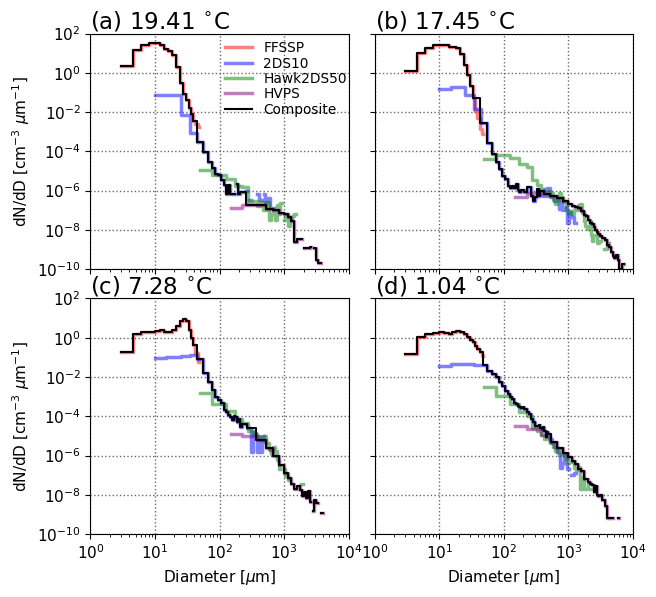

In [34]:
fig = plt.figure(figsize=(7,6.5))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

axlist = [ax1,ax2,ax3,ax4]
Fontsize=11
for ax in axlist:
    ax.tick_params(labelsize=Fontsize)
    ax.grid(which='major',lw=1,c='dimgrey',ls='dotted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1,1.e4)
    ax.set_ylim(1.e-10,1.e2)
    ax.set_yticks(10.**np.arange(-10,4,2))
    ax.set_xticks(10.**np.arange(0,5,1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    #ax.minorticks_on
    
ax3.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize)
ax4.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize)
ax1.set_ylabel('dN/dD [cm$^{-3}$ $\\mu$m$^{-1}$]',fontsize=Fontsize)
ax3.set_ylabel('dN/dD [cm$^{-3}$ $\\mu$m$^{-1}$]',fontsize=Fontsize)


dum_y_ticks = np.arange(-10,4,2)
new_y_ticks = []
for dum_y_tick in dum_y_ticks:
    new_y_ticks.append('10$^{'+str(int(dum_y_tick))+'}$')
ax1.set_yticklabels(new_y_ticks)
ax3.set_yticklabels(new_y_ticks)

dum_x_ticks = np.arange(0,5,1)
new_x_ticks = []
for dum_x_tick in dum_x_ticks:
    new_x_ticks.append('10$^{'+str(int(dum_x_tick))+'}$')
ax3.set_xticklabels(new_x_ticks)
ax4.set_xticklabels(new_x_ticks)

labs = ['(a)','(b)','(c)','(d)']
dumi=0
for key in top_dict.keys():
    tmp_mean_temp = np.around(top_dict[key]['bulk_dict']['mean_temp'],2)
    dum_str = labs[dumi]+' '+str(tmp_mean_temp)+' $^{\\circ}$C'
    axlist[dumi].text(0,1.1,dum_str,transform=axlist[dumi].transAxes,va='top',ha='left',fontsize=Fontsize*1.5)
    dumi+=1
    
    
dumi=0
for key in top_dict.keys():
    ax = axlist[dumi]
    alpha=0.5
    tmp_lw = 2.5
    #---------------------------------------
    # FFSSP
    #---------------------------------------
    tmp_ffssp_dN = top_dict[key]['dsd_dict']['ffssp']['dsd'] # dN in units of #/L
    ffssp_sizes = top_dict[key]['dsd_dict']['ffssp']['sizes']
    ffssp_mid_sizes = top_dict[key]['dsd_dict']['ffssp']['mid_sizes']
    dD = np.diff(ffssp_sizes)
    tmp_ffssp_dsd = tmp_ffssp_dN*1.e-3/dD
    ax.step(ffssp_mid_sizes,tmp_ffssp_dsd,c='red',lw=tmp_lw,where='mid',alpha=alpha,label='FFSSP')

    #---------------------------------------
    # 2DS10
    #---------------------------------------
    tmp_2ds10_dN = top_dict[key]['dsd_dict']['2ds10']['dsd'] # dN in units of #/L
    x2ds10_sizes = top_dict[key]['dsd_dict']['2ds10']['sizes']
    x2ds10_mid_sizes = top_dict[key]['dsd_dict']['2ds10']['mid_sizes']
    dD = np.diff(x2ds10_sizes)
    tmp_2ds10_dsd = tmp_2ds10_dN*1.e-3/dD
    ax.step(x2ds10_mid_sizes,tmp_2ds10_dsd,c='blue',lw=tmp_lw,where='mid',alpha=alpha,label='2DS10')    
    
    #---------------------------------------
    # Hawkeye 2DS50
    #---------------------------------------
    tmp_hawk2ds50_dN = top_dict[key]['dsd_dict']['hawk2ds50']['dsd'] # dN in units of #/L
    hawk2ds50_sizes = top_dict[key]['dsd_dict']['hawk2ds50']['sizes']
    hawk2ds50_mid_sizes = top_dict[key]['dsd_dict']['hawk2ds50']['mid_sizes']
    dD = np.diff(hawk2ds50_sizes)
    tmp_hawk2ds50_dsd = tmp_hawk2ds50_dN*1.e-3/dD
    ax.step(hawk2ds50_mid_sizes,tmp_hawk2ds50_dsd,c='green',lw=tmp_lw,where='mid',alpha=alpha,label='Hawk2DS50')        
    
    #---------------------------------------
    # HVPS
    #---------------------------------------
    tmp_hvps_dN = top_dict[key]['dsd_dict']['hvps']['dsd'] # dN in units of #/L
    hvps_sizes = top_dict[key]['dsd_dict']['hvps']['sizes']
    hvps_mid_sizes = top_dict[key]['dsd_dict']['hvps']['mid_sizes']
    dlogD = np.diff(np.log10(hvps_sizes))
    dD = np.diff(hvps_sizes)
    tmp_hvps_dsd = tmp_hvps_dN*1.e-3/dD
    ax.step(hvps_mid_sizes,tmp_hvps_dsd,c='purple',lw=tmp_lw,where='mid',alpha=alpha,label='HVPS')   
    
    
    #---------------------------------------
    # Composite DSD
    #---------------------------------------
    #tmp_comp_dN = comp_dict[key]['dN']
    tmp_comp_dNdD = comp_dict[key]['dNdD']*1.e-3
    tmp_comp_sizes = comp_dict[key]['sizes']
    #dD = comp_dict[key]['dD']
    #tmp_comp_dsd = tmp_comp_dN*1.e-3/dD
    #ax.step(tmp_comp_sizes,tmp_comp_dsd,c='k',lw=1.5,where='mid',alpha=1,label='Composite')
    ax.step(tmp_comp_sizes,tmp_comp_dNdD,c='k',lw=1.5,where='mid',alpha=1,label='Composite')
    
    dumi+=1

ax1.legend(loc='upper right',framealpha=False,fontsize=Fontsize*0.9,bbox_to_anchor=(1.04,1.02),labelspacing=0.1)

plt.subplots_adjust(wspace=0.1,hspace=0.125)

plt.show()
plt.close()


# Save cloud pass dictionary to a file that is used for DSD comparison with simulations

In [35]:
save_path = '/discover/nobackup/mwstanfo/camp2ex_data/learjet/20190925/cloud_passes/'
out_pkl_file = save_path+'camp2ex_learjet_20190925_cloud_pass_dict_paper_v2.p'
pickle.dump(top_dict,open(out_pkl_file,"wb"))   

# Print thermodynamic and kinematic statistics of each cloud pass for Table 2, which is a summary of each cloud pass

In [36]:
for key in top_dict.keys():
    print(key)
    print('   LWC:',top_dict[key]['bulk_dict']['mean_NevLWC'],top_dict[key]['bulk_dict']['max_NevLWC'])
    print('     w:',top_dict[key]['bulk_dict']['mean_w'],top_dict[key]['bulk_dict']['max_w'])
    print('  Temp:',top_dict[key]['bulk_dict']['mean_temp'],top_dict[key]['bulk_dict']['max_temp'],top_dict[key]['bulk_dict']['min_temp'])

14
   LWC: 0.2461538461538462 0.5
     w: 0.7615384615384616 1.6
  Temp: 19.407692307692308 19.8 19.0
16
   LWC: 0.6518987341772151 1.4
     w: 1.377215189873418 4.8
  Temp: 17.44810126582279 19.2 15.0
8
   LWC: 1.15 1.8
     w: -2.816666666666667 -1.0
  Temp: 7.283333333333332 8.9 5.9
19
   LWC: 0.6181818181818182 0.9
     w: 4.154545454545454 9.2
  Temp: 1.0363636363636366 2.0 0.3


# Compute Reff, Reff < 100 um, and Nd from the composite size distributions for Table 2 in the manuscript

In [38]:
for key in top_dict.keys():
    print(key)
    comp_dsd = top_dict[key]['comp']['dN'].copy()
    comp_dsd[np.isnan(comp_dsd)] = 0.
    dD = top_dict[key]['comp']['dD'].copy()
    sizes = top_dict[key]['comp']['sizes'].copy()
    rad_sizes = sizes/2.
    comp_dsd = comp_dsd/dD*1.e-3 # /cc /um
    
    nd = np.trapz(comp_dsd,sizes)
    r4 = np.trapz(comp_dsd*1.e6*(rad_sizes**4.),rad_sizes)
    r3 = np.trapz(comp_dsd*1.e6*(rad_sizes**3.),rad_sizes)
    r2 = np.trapz(comp_dsd*1.e6*(rad_sizes**2.),rad_sizes)
    reff = r3/r2
    veff = (r4*r2)/(r3**2.)-1.
    
    dumid = np.where(rad_sizes <= 100)[0]
    r4 = np.trapz(comp_dsd[dumid]*1.e6*(rad_sizes[dumid]**4.),rad_sizes[dumid])
    r3 = np.trapz(comp_dsd[dumid]*1.e6*(rad_sizes[dumid]**3.),rad_sizes[dumid])
    r2 = np.trapz(comp_dsd[dumid]*1.e6*(rad_sizes[dumid]**2.),rad_sizes[dumid])
    reff_lt_100um = r3/r2
    veff_lt_100um = (r4*r2)/(r3**2.)-1.
    
    print('   Nd:',nd)
    print('   Reff:',reff)
    print('   Reff < 100 um:',reff_lt_100um)
    print('   Veff:',veff)
    print('   Veff < 100 um:',veff_lt_100um)
    print('')

14
   Nd: 348.11868078525566
   Reff: 8.10305438688586
   Reff < 100 um: 7.354595153537824
   Veff: 8.690923535298765
   Veff < 100 um: 0.10586468862410725

16
   Nd: 383.6373610942087
   Reff: 16.716096303648968
   Reff < 100 um: 8.869182927376743
   Veff: 71.97302895387108
   Veff < 100 um: 0.09133109043464316

8
   Nd: 127.86900277124934
   Reff: 18.45090059360147
   Reff < 100 um: 15.168360984347878
   Veff: 6.265287775608126
   Veff < 100 um: 0.1178609310018428

19
   Nd: 51.76666195064654
   Reff: 55.223601781449055
   Reff < 100 um: 19.12903091769579
   Veff: 8.713654301990593
   Veff < 100 um: 0.5976280226366739



/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_31174/3646597741.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  nd = np.trapz(comp_dsd,sizes)
/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_31174/3646597741.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  r4 = np.trapz(comp_dsd*1.e6*(rad_sizes**4.),rad_sizes)
/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_31174/3646597741.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  r3 = np.trapz(comp_dsd*1.e6*(rad_sizes**3.),rad_sizes)
/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_31174/3646597741.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions 